# Optimization and Performance Analysis

## Overview
This notebook focuses on optimizing dimensionality reduction techniques and analyzing comprehensive performance metrics across different classifiers and component numbers for lung cancer classification.

## Table of Contents
1. Setup and Data Loading
2. Component Optimization Functions
3. Comprehensive Performance Testing
4. Results Analysis and Visualization
5. Final Recommendations

## Dataset Information
- **Dataset**: Lung.csv
- **Optimization Range**: 1-30 components
- **Classifiers**: Multiple algorithms comparison
- **Metrics**: Accuracy, Runtime, Efficiency analysis

## Author
- Raja Ram Bitra

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from scipy.linalg import solve, pinv
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Classifier Implementations from Notebook 03
- All classifier implementations used in the comprehensive evaluation, including custom implementations and sklearn classifiers.

In [2]:
# Minimum Distance Classifier (from scratch)
def min_distance_classifier(X_train, y_train, X_test):
    classes = np.unique(y_train)
    class_means = {}
    for c in classes:
        class_means[c] = np.mean(X_train[y_train == c], axis=0)
    
    predictions = []
    for x in X_test:
        dists = [np.linalg.norm(x-class_means[c]) for c in classes]
        predictions.append(classes[np.argmin(dists)])
    return np.array(predictions)

print("Minimum Distance Classifier implemented")

Minimum Distance Classifier implemented


In [3]:
# Bayes Classifier (from scratch)
class BayesClassifier:
    def __init__(self):
        self.classes = None
        self.priors = None
        self.mean = None
        self.variance = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes)
        # Initialize arrays to store class-wise statistics
        self.mean = np.zeros((n_classes, n_features))
        self.variance = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.variance[idx, :] = X_c.var(axis=0)
            self.priors[idx] = X_c.shape[0] / float(X.shape[0])
    
    def _calculate_likelihood(self, mean, var, x):
        eps = 1e-6  # Add small epsilon to variance to avoid division by zero
        coeff = 1 / np.sqrt(2 * np.pi * var + eps)
        exponent = -((x - mean) ** 2) / (2 * (var + eps))
        return coeff * np.exp(exponent)
    
    def _calculate_posterior(self, X):
        posteriors = []
        for idx, cls in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            likelihood = np.sum(np.log(self._calculate_likelihood(self.mean[idx, :], self.variance[idx, :], X)), axis=1)
            posteriors.append(prior + likelihood)
        return np.array(posteriors).T

    def predict(self, X):
        posteriors = self._calculate_posterior(X)
        return self.classes[np.argmax(posteriors, axis=1)]

print("Bayes Classifier implemented")

Bayes Classifier implemented


In [4]:
# Kernel Discriminant Analysis (from scratch)
class KernelDiscriminantAnalysis:
    def __init__(self, kernel='linear', degree=3, coef0=1, gamma=None, reg=1e-3):
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.reg = reg
        self.eigenvectors = None
        self.class_means = None
        self.X_train = None
        self.y_train = None
        self.label_dict = {}

    def compute_kernel(self, X, Y=None):
        if self.kernel == 'rbf':
            return rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'poly':
            return polynomial_kernel(X, Y, degree=self.degree, coef0=self.coef0)
        elif self.kernel == 'linear':
            return linear_kernel(X, Y)
        else:
            raise ValueError("Unsupported kernel. Choose from 'rbf', 'poly', or 'linear'.")

    def encode_labels(self, y):
        unique_classes = np.unique(y)
        self.label_dict = {label: idx for idx, label in enumerate(unique_classes)}
        return np.array([self.label_dict[label] for label in y])

    def fit(self, X, y):
        self.X_train = X
        self.y_train = self.encode_labels(y)

        n_samples = X.shape[0]
        K = self.compute_kernel(X)

        classes = np.unique(self.y_train)
        N_c, K_c, mean_c = {}, {}, {}

        # Compute class-wise kernel matrices
        for c in classes:
            idx = np.where(self.y_train == c)[0]
            K_c[c] = K[:, idx]
            N_c[c] = len(idx)
            mean_c[c] = np.mean(K_c[c], axis=1, keepdims=True)

        # Compute between-class scatter matrix M
        mean_total = np.mean(K, axis=1, keepdims=True)
        M = np.zeros((n_samples, n_samples))
        for c in classes:
            diff = mean_c[c] - mean_total
            M += N_c[c] * (diff @ diff.T)

        # Compute within-class scatter matrix N
        N = np.zeros((n_samples, n_samples))
        for c in classes:
            N += K_c[c] @ (np.eye(N_c[c]) - (1 / N_c[c]) * np.ones((N_c[c], N_c[c]))) @ K_c[c].T

        # Regularize N to ensure positive definiteness
        N += np.eye(N.shape[0]) * self.reg

        # Solve the generalized eigenvalue problem
        try:
            eigvals, eigvecs = np.linalg.eig(solve(N, M))
        except np.linalg.LinAlgError:
            print("Warning: N is singular, using pseudo-inverse instead.")
            eigvals, eigvecs = np.linalg.eig(pinv(N) @ M)

        # Select top discriminant directions
        idx = np.argsort(-eigvals)
        self.eigenvectors = eigvecs[:, idx[:len(classes) - 1]]

        # Normalize eigenvectors
        self.eigenvectors /= np.linalg.norm(self.eigenvectors, axis=0)

        # Compute class means in the transformed space
        self.class_means = {}
        transformed_X = self.transform(X)
        for c in classes:
            self.class_means[c] = np.mean(transformed_X[self.y_train == c], axis=0)

    def transform(self, X):
        K_test = self.compute_kernel(X, self.X_train)
        return K_test @ self.eigenvectors

    def predict(self, X):
        X_proj = self.transform(X)
        predictions = []
        for x in X_proj:
            # Assign to nearest class mean
            distances = {c: np.linalg.norm(x - self.class_means[c]) for c in self.class_means}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

print("Kernel Discriminant Analysis implemented")

Kernel Discriminant Analysis implemented


## 4a. Setup and Data Loading
- Loading the lung cancer dataset and preparing it for systematic optimization analysis across different component numbers and classification algorithms.

In [5]:
# Load and prepare data
df = pd.read_csv('../Lung.csv')
data = df.iloc[:,:-1].to_numpy()
label = df.iloc[:, -1].to_numpy()

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

print(f"Dataset loaded: {data.shape}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Dataset loaded: (1091, 1881)
Training set: (872, 1881)
Test set: (219, 1881)


## 4b. Component Optimization Functions
- Development of systematic optimization functions to find the optimal number of PCA components for different classification algorithms through automated testing and performance tracking.

In [6]:
def run_classifier(clf_name, X_train, y_train, X_test):
    if clf_name == 'min_dist':
        return min_distance_classifier(X_train, y_train, X_test)
    
    elif clf_name == 'BayesClassifier':
        model = BayesClassifier()
        model.fit(X_train, y_train)
        return model.predict(X_test)
    
    elif clf_name == 'naive_bayes':
        model = GaussianNB()
        model.fit(X_train, y_train)
        return model.predict(X_test)
    
    elif clf_name == 'knn':
        model = KNeighborsClassifier(n_neighbors=10)
        model.fit(X_train, y_train)
        return model.predict(X_test)
    
    elif clf_name == 'lda':
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)
        return model.predict(X_test)
    
    elif clf_name in ['kda_rbf', 'kda_poly', 'kda_linear']:
        kernel_type = clf_name.split('_')[1]
        model = KernelDiscriminantAnalysis(kernel=kernel_type)
        model.fit(X_train, y_train)
        return model.predict(X_test)
    
    else:
        raise ValueError(f"Unknown classifier name: {clf_name}")

In [7]:
def find_best_n_components(classifier_name, X_train, y_train, X_test, y_test, max_components=30):
    accuracies = []
    times = []
    n_components_list = range(1, min(max_components + 1, X_train.shape[1] + 1))
    
    for n in n_components_list:
        start_time = time.time()
        
        # Apply PCA
        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_pca)
        X_test_scaled = scaler.transform(X_test_pca)
        
        try:
            # Train classifier using unified function
            predictions = run_classifier(classifier_name, X_train_scaled, y_train, X_test_scaled)
            accuracy = accuracy_score(y_test, predictions)
            accuracies.append(accuracy)
        except Exception as e:
            print(f"Error with {classifier_name} at {n} components: {e}")
            accuracies.append(0.0)
        
        end_time = time.time()
        times.append(end_time - start_time)
        
        if n % 5 == 0:  # Print progress every 5 components
            print(f"Components: {n}, Accuracy: {accuracies[-1]:.4f}, Time: {times[-1]:.4f}s")
    
    best_idx = np.argmax(accuracies)
    best_n = list(n_components_list)[best_idx]
    
    return best_n, accuracies, times, list(n_components_list)

## 4c. Comprehensive Performance Testing
- Systematic evaluation of multiple classifiers across different component numbers to identify optimal configurations and analyze performance trade-offs.

In [8]:
# Run optimization for all classifiers
classifiers_to_optimize = [
    'min_dist',
    'BayesClassifier', 
    'naive_bayes',
    'knn',
    'lda',
    'kda_rbf',
    'kda_poly',
    'kda_linear'
]

optimization_results = {}

print("Starting comprehensive performance testing with all classifiers...")
print("=" * 70)

for clf_name in classifiers_to_optimize:
    print(f"\nOptimizing {clf_name.upper()}...")
    try:
        best_n, accuracies, times, n_components_list = find_best_n_components(
            clf_name, X_train, y_train, X_test, y_test, max_components=30
        )
        
        optimization_results[clf_name] = {
            'best_n_components': best_n,
            'best_accuracy': max(accuracies),
            'accuracies': accuracies,
            'times': times,
            'n_components_list': n_components_list
        }
        
        print(f"Best configuration for {clf_name}:")
        print(f"- Components: {best_n}")
        print(f"- Accuracy: {max(accuracies):.4f}")
        print(f"- Average time: {np.mean(times):.4f}s")
        
    except Exception as e:
        print(f"Error optimizing {clf_name}: {e}")
        optimization_results[clf_name] = {
            'best_n_components': 0,
            'best_accuracy': 0.0,
            'accuracies': [],
            'times': [],
            'n_components_list': []
        }

print(f"\nOptimization completed for all {len(classifiers_to_optimize)} classifiers!")

Starting comprehensive performance testing with all classifiers...

Optimizing MIN_DIST...
Components: 5, Accuracy: 0.1233, Time: 0.1212s
Components: 10, Accuracy: 0.1553, Time: 0.1402s
Components: 15, Accuracy: 0.1598, Time: 0.3590s
Components: 20, Accuracy: 0.1735, Time: 0.2332s
Components: 25, Accuracy: 0.1689, Time: 0.2757s
Components: 30, Accuracy: 0.2192, Time: 0.2087s
Best configuration for min_dist:
- Components: 28
- Accuracy: 0.2192
- Average time: 0.2163s

Optimizing BAYESCLASSIFIER...
Components: 5, Accuracy: 0.4932, Time: 0.1162s
Components: 10, Accuracy: 0.4795, Time: 0.1449s
Components: 15, Accuracy: 0.4064, Time: 0.1349s
Components: 20, Accuracy: 0.3699, Time: 0.2016s
Components: 25, Accuracy: 0.3379, Time: 0.1611s
Components: 30, Accuracy: 0.3744, Time: 0.1604s
Best configuration for BayesClassifier:
- Components: 2
- Accuracy: 0.5251
- Average time: 0.1512s

Optimizing NAIVE_BAYES...
Components: 5, Accuracy: 0.4932, Time: 0.1122s
Components: 10, Accuracy: 0.4795, Time

## 4d. Results Analysis and Visualization
- Comprehensive analysis of optimization results across all classifiers with detailed performance comparisons and visualizations.

In [9]:
# Create comprehensive results summary
print("\n" + "="*80)
print("COMPREHENSIVE OPTIMIZATION RESULTS SUMMARY")
print("="*80)

# Create summary DataFrame
summary_data = []
for clf_name, results in optimization_results.items():
    if results['best_accuracy'] > 0:  # Only include successful optimizations
        summary_data.append({
            'Classifier': clf_name,
            'Best_Components': results['best_n_components'],
            'Best_Accuracy': results['best_accuracy'],
            'Avg_Time': np.mean(results['times']) if results['times'] else 0.0
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Best_Accuracy', ascending=False)
    
    print("\nTop Performing Classifiers:")
    print("-" * 50)
    for idx, row in summary_df.iterrows():
        print(f"{row['Classifier']:15} | {row['Best_Components']:3d} components | {row['Best_Accuracy']:.4f} accuracy | {row['Avg_Time']:.4f}s avg")
    
    print(f"\nBest Overall Performance:")
    best_row = summary_df.iloc[0]
    print(f"Classifier: {best_row['Classifier']}")
    print(f"Optimal Components: {best_row['Best_Components']}")
    print(f"Best Accuracy: {best_row['Best_Accuracy']:.4f}")
    print(f"Average Time: {best_row['Avg_Time']:.4f}s")
else:
    print("No successful optimizations completed.")


COMPREHENSIVE OPTIMIZATION RESULTS SUMMARY

Top Performing Classifiers:
--------------------------------------------------
knn             |  25 components | 0.5297 accuracy | 0.2079s avg
BayesClassifier |   2 components | 0.5251 accuracy | 0.1512s avg
naive_bayes     |   2 components | 0.5251 accuracy | 0.1612s avg
lda             |   8 components | 0.5205 accuracy | 0.1499s avg
kda_rbf         |  29 components | 0.4703 accuracy | 1.6285s avg
kda_poly        |  30 components | 0.4110 accuracy | 1.5471s avg
min_dist        |  28 components | 0.2192 accuracy | 0.2163s avg
kda_linear      |  28 components | 0.2192 accuracy | 1.6257s avg

Best Overall Performance:
Classifier: knn
Optimal Components: 25
Best Accuracy: 0.5297
Average Time: 0.2079s


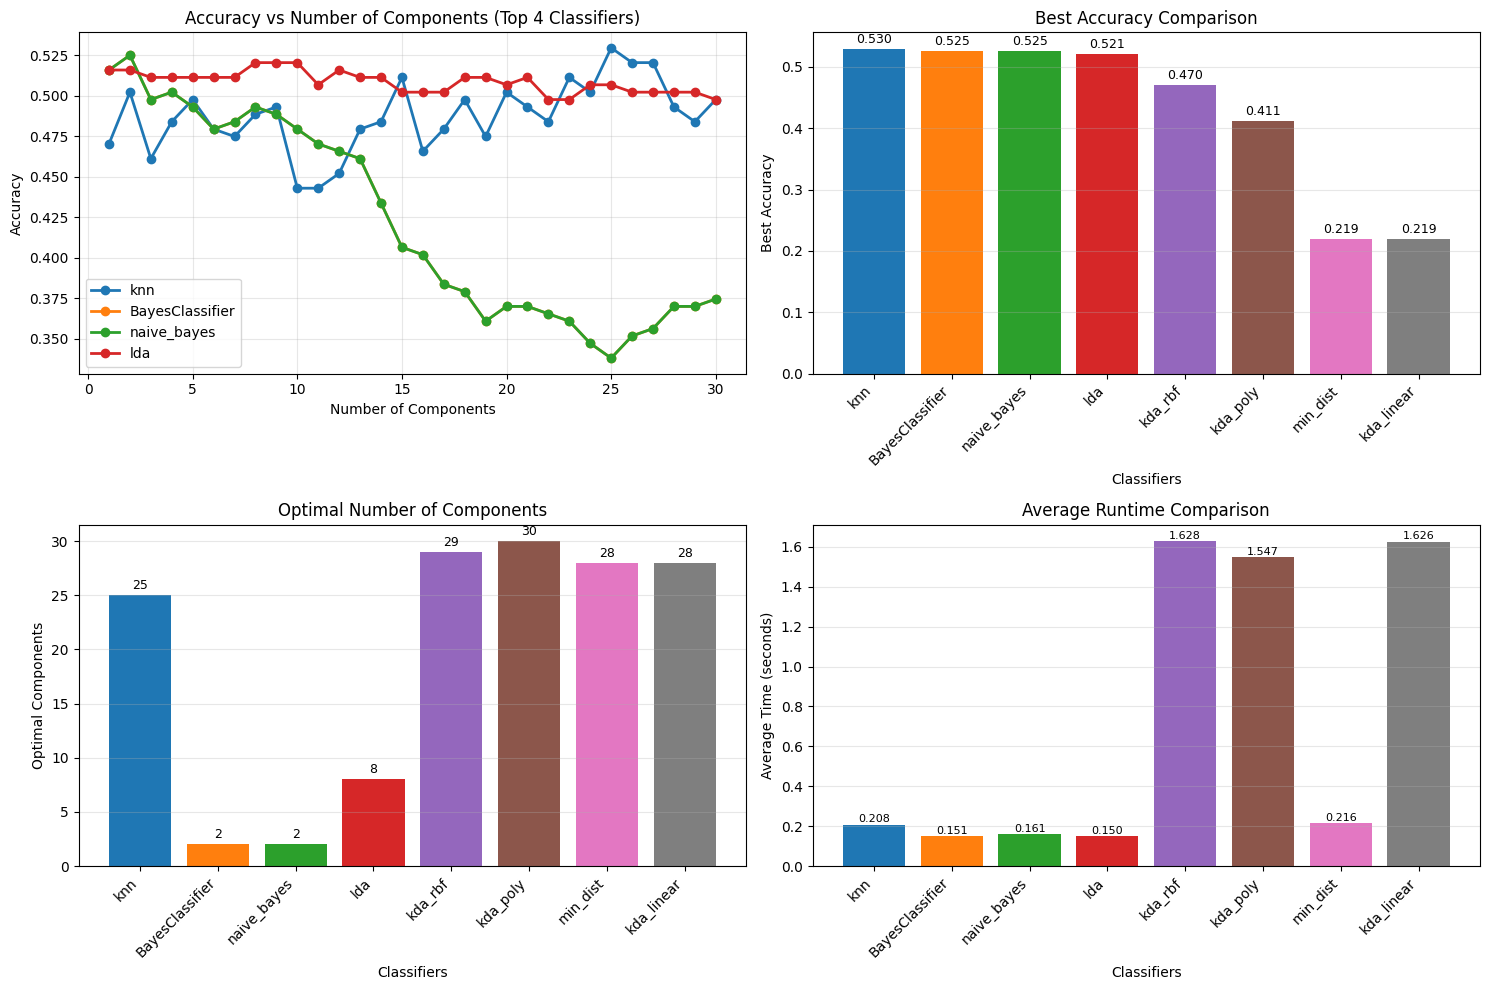

In [10]:
# Performance visualization
if summary_data:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Accuracy vs Components for top performers
    plt.subplot(2, 2, 1)
    top_classifiers = summary_df.head(4)['Classifier'].tolist()
    
    for clf_name in top_classifiers:
        if clf_name in optimization_results and optimization_results[clf_name]['accuracies']:
            results = optimization_results[clf_name]
            plt.plot(results['n_components_list'], results['accuracies'], 
                    marker='o', linewidth=2, label=clf_name)
    
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Components (Top 4 Classifiers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Best accuracy comparison
    plt.subplot(2, 2, 2)
    classifiers = summary_df['Classifier'].tolist()
    accuracies = summary_df['Best_Accuracy'].tolist()
    
    bars = plt.bar(range(len(classifiers)), accuracies, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'][:len(classifiers)])
    plt.xlabel('Classifiers')
    plt.ylabel('Best Accuracy')
    plt.title('Best Accuracy Comparison')
    plt.xticks(range(len(classifiers)), classifiers, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Optimal components comparison
    plt.subplot(2, 2, 3)
    components = summary_df['Best_Components'].tolist()
    
    bars = plt.bar(range(len(classifiers)), components, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'][:len(classifiers)])
    plt.xlabel('Classifiers')
    plt.ylabel('Optimal Components')
    plt.title('Optimal Number of Components')
    plt.xticks(range(len(classifiers)), classifiers, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Runtime comparison
    plt.subplot(2, 2, 4)
    avg_times = summary_df['Avg_Time'].tolist()
    
    bars = plt.bar(range(len(classifiers)), avg_times, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'][:len(classifiers)])
    plt.xlabel('Classifiers')
    plt.ylabel('Average Time (seconds)')
    plt.title('Average Runtime Comparison')
    plt.xticks(range(len(classifiers)), classifiers, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")